In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image as Img
import tensorflow as tf
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop

In [13]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
os.getcwd()

'/Users/karanhadiyal/Desktop/Music generation/ipynb files and model'

In [17]:
PIC_DIR = "/Users/karanhadiyal/Desktop/Music generation//processed images/"
IMAGES_COUNT = 14000

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Img.open(PIC_DIR + pic_file)
    images.append(np.uint8(pic))

100%|███████████████████████████████████| 14000/14000 [00:02<00:00, 4719.24it/s]


In [18]:
WIDTH = 300
HEIGHT = 106
images = np.array(images) / 255
images = images.reshape(14000,106,300,1)
print(images.shape)

(14000, 106, 300, 1)


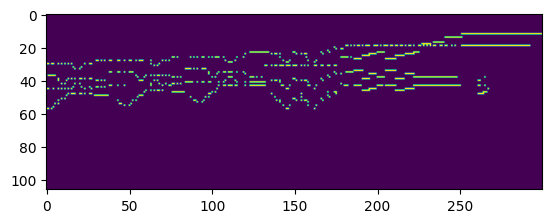

In [19]:
plt.imshow(images[30])

In [20]:
LATENT_DIM = 14
CHANNELS = 1

def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 14 * 40)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((14, 40, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, (7,21), activation='tanh', padding='valid')(x)

    generator = Model(gen_input, x)
    return generator

In [21]:
generator = create_generator()
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense_1 (Dense)             (None, 71680)             1075200   
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 71680)             0         
                                                                 
 reshape_1 (Reshape)         (None, 14, 40, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 40, 256)       819456    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 40, 256)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 28, 80, 256)      1048

In [22]:
def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator

In [23]:
discriminator = create_discriminator()
discriminator.trainable = False
discriminator.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 106, 300, 1)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 104, 298, 256)     2560      
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 104, 298, 256)     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 51, 148, 256)      1048832   
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 51, 148, 256)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 73, 256)       1048832   
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 24, 73, 256)       0   

/Users/karanhadiyal/anaconda3/lib/python3.10/site-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

In [ ]:
optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [ ]:
import time
iters = 1000
batch_size = 16

RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)

    real = images[start : start+batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    
    if start > images.shape[0] - batch_size:
        start = 0

    if step % 50 == 49:
        generator.save(os.getcwd() + "/models/" + str(step) + ".h5")

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Img.fromarray(np.uint8(control_image * 255))#.save(StringIO(), 'jpeg')
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1